NAME: __TODO: Vignesh Murugan

# Machine Learning Practice - Asynchronous
## Homework 05: Regularization 

### Data set
The dataset is identical to what we used in HW04


### Task
For this assignment you will be exploring **regularization.** Regularization
is a powerful tool in machine learning to impose rational constraints on 
models during the training process to mitigate overfitting to the training 
set and improve model generalization. By including one or more terms within
the cost (error) function to penalize large weights, the learning algorithm will try 
to fit the data while avoiding certain values for the weights that might lead to
overfitting of the training data.


### Objectives
* Use and understand regularization in regression
* Learn to select hyper-parameters to tune model behavior


### Instructions
* All Homework must be individual work.  Do not look at or copy solutions of other students or that are available on the Internet or via LLMs
* Only work in a copy of the file that is from your ~/homework_in/ directory
   + __If you do not use your own copy of this file, then it is an automatic zero on the assignment__
* Read the code below 
* For any cell that is flagged as *TODO*, complete the code according to the specifications
* Execute each cell and verify that it is showing correct results.  Note that because we are reusing variables, the order of execution is *really* important.
* Hand-In Procedure
  + Make sure that your notebook has been saved.  You are responsible for ensuring that the copy that you submit is current and complete
  + The name of the file should be the same as what we gave you
  + Download this file to your local machine (extension: .ipynb)
  + Submit to the Gradescope Notebook HW05 dropbox



### General References
* [Python Built-in Functions](https://docs.python.org/3/library/functions.html)
* [Python Data Structures](https://docs.python.org/3/tutorial/datastructures.html)
* [Numpy Reference](https://docs.scipy.org/doc/numpy/reference/index.html)
* [Summary of matplotlib](https://matplotlib.org/3.1.1/api/pyplot_summary.html)
* [Pandas DataFrames](https://urldefense.proofpoint.com/v2/url?u=https-3A__pandas.pydata.org_pandas-2Ddocs_stable_reference_api_pandas.DataFrame.html&d=DwMD-g&c=qKdtBuuu6dQK9MsRUVJ2DPXW6oayO8fu4TfEHS8sGNk&r=9ngmsG8rSmDSS-O0b_V0gP-nN_33Vr52qbY3KXuDY5k&m=mcOOc8D0knaNNmmnTEo_F_WmT4j6_nUSL_yoPmGlLWQ&s=h7hQjqucR7tZyfZXxnoy3iitIr32YlrqiFyPATkW3lw&e=)
* [Sci-kit Learn Linear Models](https://scikit-learn.org/stable/api/sklearn.linear_model.html)
* [Sci-kit Learn Model Selection](https://scikit-learn.org/stable/api/sklearn.model_selection.html)
* [JobLib](https://joblib.readthedocs.io/en/latest/)


In [1]:
# PROVIDED
import pickle as pkl
import pandas as pd
import numpy as np
import os, re, fnmatch, time
import matplotlib.pyplot as plt
import joblib
import copy

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.metrics import make_scorer

# Default figure parameters
plt.rcParams['figure.figsize'] = (10,7)
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 12
plt.style.use('default')
                                   
%matplotlib inline

# LOAD DATA

In [2]:
""" PROVIDED: Execute cell
Load the BMI data from all the folds
"""
fname = '/mlp/datasets/bmi/bmi_dataset.pkl'

with open(fname, 'rb') as f:
    bmi = pkl.load(f)
    theta_folds = bmi['theta']
    dtheta_folds = bmi['dtheta']
    ddtheta_folds = bmi['ddtheta']
    torque_folds = bmi['torque']
    time_folds = bmi['time']
    MI_folds = bmi['MI'] 

print("Number of folds:", len(MI_folds))

Number of folds: 20


# Helper Functions

In [3]:
""" PROVIDED
Evaluate the performance of an already trained model

"""

def predict_score_eval(model, X, y, convert_deg=False):
    '''
    
    Compute the model predictions and cooresponding scores.
    PARAMS:
        model: the trained model used to make predicitons
        X: feature data (MxN)
        y: desired output (Mxk)
        convert_deg: Boolean flag to indicate whether rmse should be
            converted from rad to deg
            
    RETURNS:
        mse: mean squared error for each column (k vector)
        rmse: rMSE (k vector)
        fvaf: fraction of variance accounted for metric (k vector)
        preds: predictions made by the model (M x k matrix)
    '''
    # use the model to predict the outputs from the input data
    preds = model.predict(X) 
    

    # Compute VAR/MSE/RMSE
    mse = np.sum(np.square(y - preds), axis=0) / y.shape[0] 
    var = np.var(y, axis=0)

    fvaf = 1 - mse/var 
    
    rmse = np.sqrt(mse) 
    
    if convert_deg:
        rmse = rmse * 180 / np.pi 

    return mse, rmse, fvaf, preds, var




In [4]:
'''
PROVIDED: Execute Cell
'''
def extract_data_set(folds, data):
    '''
    For the data provided, extract only the specified folds and concatenate them together
    
    :param folds: Python list of fold indices to extract
    :param data: Python list of all folds of any number of data fields (e.g., 20 folds 
        of ddtheta and torque)
    
    :return: Tuple of the specific types, containing only the specified folds
    '''
    # For each field in data, extract only the specified folds
    output = [np.concatenate([d[f] for f in folds]) for d in data]
    
    # Convert the list to a tuple
    return tuple(output)

In [5]:
"""
TODO

Construct training, validation and test sets

Training set: used for selecting model parameters
Validation set: used for selecting model hyper-parameters
Test set: used sparingly to evaluate the final models

We are building models to predict joint position
"""
# Extract fold indices for the training, validation and testing sets
trainset_fold_inds = [19] 
validationset_fold_inds = [0, 1, 2, 3] 
testset_fold_inds = [4, 5, 6, 7] 

# Data to predict: Joint position
predict_folds = theta_folds

# We are focusing on just the elbow
predict_index = 1

# Combine the folds into singular numpy arrays for each of the Training, Validation and Testing sets
#  Use extract_data_set() above

# Training set
timetrain, Xtrain, ytrain = extract_data_set(trainset_fold_inds, [time_folds, MI_folds, predict_folds])  
# Extract just the predict_index
ytrain = np.squeeze(ytrain[:,predict_index]) 

# Validation set
timeval, Xval, yval = extract_data_set(validationset_fold_inds, [time_folds, MI_folds, predict_folds])
yval = np.squeeze(yval[:,predict_index]) 

# Testing set
timetest, Xtest, ytest = extract_data_set( testset_fold_inds, [time_folds, MI_folds, predict_folds])
ytest = np.squeeze(ytest[:,predict_index]) 


In [6]:
# PROVIDED: Execute Cell

print('Train:', Xtrain.shape, ytrain.shape)
print('Validation:', Xval.shape, yval.shape)
print('Test:', Xtest.shape, ytest.shape)

Train: (1289, 960) (1289,)
Validation: (5093, 960) (5093,)
Test: (5255, 960) (5255,)


## Linear Model

In [7]:
""" TODO
Construct and train a model using the training set.  This model is a pipeline:
- StandardScaler
- LinearRegression

Display the Training set rmse (degrees) and fvaf
"""

model_lnr = Pipeline([
 ('scalar', StandardScaler()),
 ('linear regression', LinearRegression())
])

model_lnr.fit(Xtrain, ytrain)

# Show the performance of the model with respect to the training set
#  Print FVAF and RMSE (latter in degrees) 

mse, rmse_deg, fvaf, pred, var = predict_score_eval(model_lnr, Xtrain, ytrain, convert_deg=True)
print(fvaf, rmse_deg)

0.9445110247080654 3.096725015149331


In [8]:
# TODO
# Show model performance with respect to the validation data set
#  Print FVAF and RMSE (latter in degrees) 
mse, rmse_deg, fvaf, pred, var = predict_score_eval(model_lnr, Xval, yval, convert_deg=True)
print(fvaf, rmse_deg)

-0.5390325020221813 16.25495219137984


In [9]:
# DELETE
# Show model performance with respect to the test data set
#  Print FVAF and RMSE (latter in degrees) 
mse, rmse_deg, fvaf, pred, var = predict_score_eval(model_lnr, Xtest, ytest, convert_deg=True)
print(fvaf, rmse_deg)

-0.4321978945720679 16.915778259137955


## Regularized Regression

In [10]:
# TODO

# Create a Lasso model Pipeline:
# - StandardScalar()
# - Lasso()

model_regularized = Pipeline([
 ('scalar', StandardScaler()),
 ('lasso regression', Lasso())
])

# A set of alpha parameter values to try 
#  These are factors of 10 from 10^-7 to 10^0 spaced exponentially 

alphas = np.logspace(-7, 0, base=10, num=28, endpoint=True)
alphas

array([1.00000000e-07, 1.81659979e-07, 3.30003479e-07, 5.99484250e-07,
       1.08902296e-06, 1.97831888e-06, 3.59381366e-06, 6.52852114e-06,
       1.18597101e-05, 2.15443469e-05, 3.91374560e-05, 7.10970943e-05,
       1.29154967e-04, 2.34622885e-04, 4.26215883e-04, 7.74263683e-04,
       1.40652724e-03, 2.55509709e-03, 4.64158883e-03, 8.43190929e-03,
       1.53174046e-02, 2.78255940e-02, 5.05479682e-02, 9.18254284e-02,
       1.66810054e-01, 3.03027108e-01, 5.50478981e-01, 1.00000000e+00])

In [11]:
# TODO

def hyperparameter_loop(model, alphas, Xtrain, ytrain, Xval, yval, convert_deg=False):
    '''
    Loop over all possible alphas:
    - Set the Lasso model alpha parameter to the specific alpha
    - Fit model to Xtrain/ytrain
    - Compute rmse (DEG) and FVAF for Xtrain/ytrain and Xval/yval & record these in 
            numpy arrays 
     Return the fvaf amd rmse_degree for both the training and validation sets
    
    :param model: ML model to fit
    :param alphas: List of alpha hyper-parameter values to try
    :param Xtrain: training set inputs
    :param ytrain: training set desired output
    :param Xval: validation set inputs
    :param yval: validation set desired output
    :param convert_deg: Convert from radians to degrees
    
    :return: rmse/fvaf for the training set and validation set, as well as the zero coefficient count
    '''
    rmse_train = np.zeros((len(alphas),))
    rmse_valid = np.zeros((len(alphas),))
    fvaf_train = np.zeros((len(alphas),))
    fvaf_valid = np.zeros((len(alphas),))
    zero_count = np.zeros((len(alphas),))
    
    # Loop over all possible alphas
    for i, a in enumerate(alphas):
        # Copy model
        model_tmp = copy.deepcopy(model)
        
        # Set alpha property of the Lasso model
        model_tmp.set_params(**{'lasso regression__alpha': a})
        
        # Fit the model to the training set
        
        model_tmp.fit(Xtrain, ytrain)
        
        # Record rmse/fvaf for both training and validation sets
        _, rmse_deg, fvaf, _, _ = predict_score_eval(model_tmp, Xtrain, ytrain, convert_deg = convert_deg)
        rmse_train[i] = rmse_deg
        fvaf_train[i] = fvaf
        
        _, rmse_deg, fvaf, _, _ = predict_score_eval(model_tmp, Xval, yval, convert_deg = convert_deg)
        rmse_valid[i] = rmse_deg
        fvaf_valid[i] = fvaf
        
        # Count and the number of model parameters that are exactly zero
        zero_count[i] =  np.sum(model_tmp.named_steps['lasso regression'].coef_ == 0)
        
        
    # Return training and validation performance arrays
    return rmse_train, fvaf_train, rmse_valid, fvaf_valid, zero_count

In [12]:
# TODO
# Call hyperparameter_loop with the regularized model
rmse_train, fvaf_train, rmse_valid, fvaf_valid, zero_count = hyperparameter_loop(model_regularized, alphas, Xtrain, ytrain, Xval, yval)


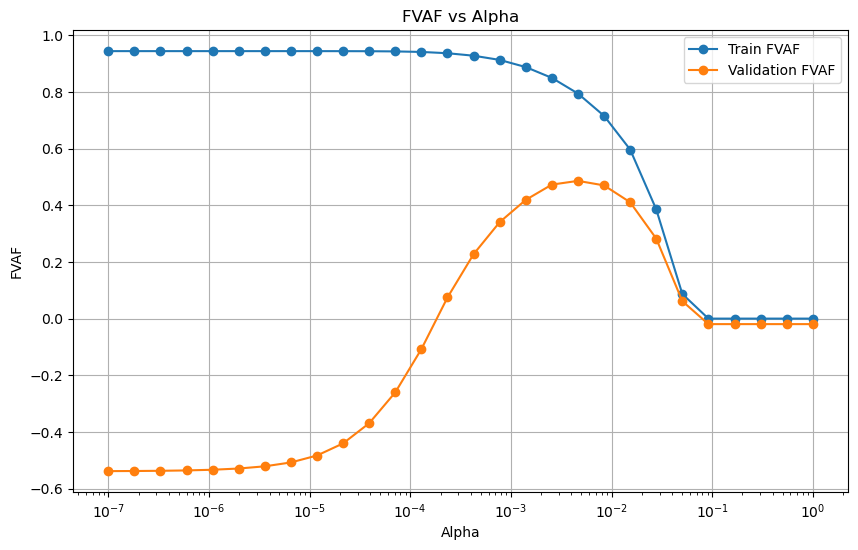

In [13]:
# TODO
# Plot training and validation FVAF as a function of alpha
#  Set the xscale to 'log'

plt.figure(figsize=(10, 6))
plt.plot(alphas, fvaf_train, label='Train FVAF', marker = 'o')
plt.plot(alphas, fvaf_valid, label='Validation FVAF', marker = 'o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('FVAF')
plt.title('FVAF vs Alpha')
plt.legend()
plt.grid(True)
plt.show()


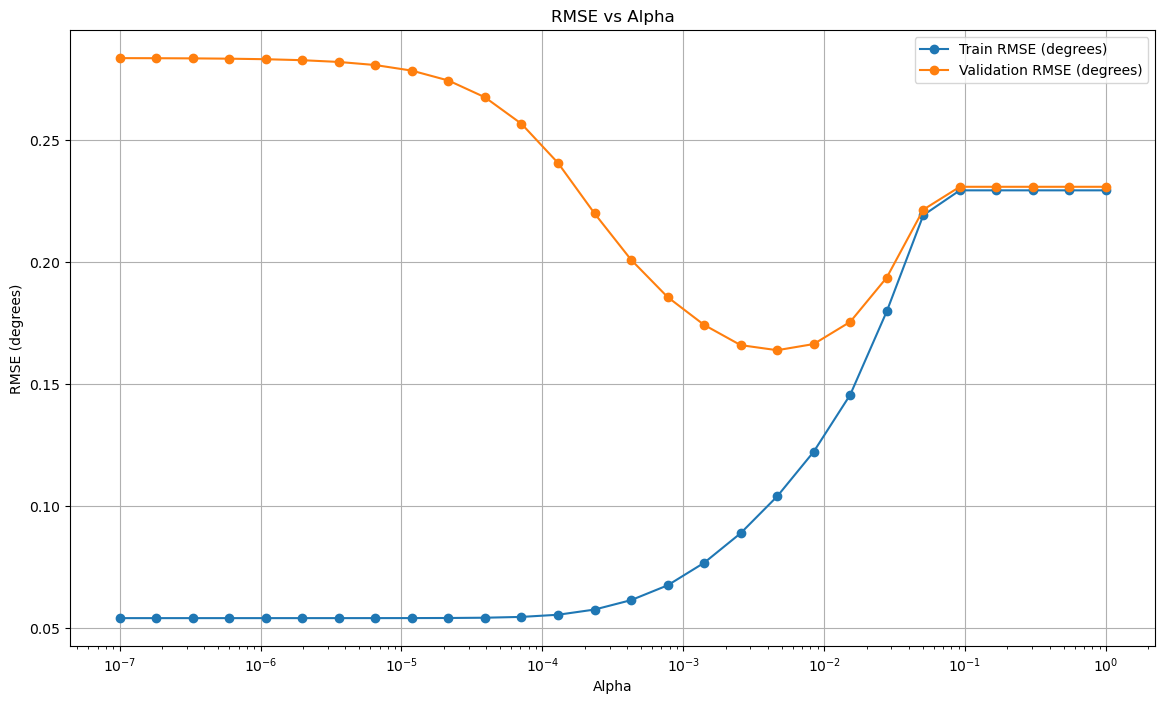

In [14]:
# TODO
# Plot training and validation rmse as a function of alpha
#  Set the xscale to 'log'

plt.figure(figsize=(14, 8))
plt.plot(alphas, rmse_train, label='Train RMSE (degrees)', marker = 'o')
plt.plot(alphas, rmse_valid, label='Validation RMSE (degrees)', marker = 'o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE (degrees)')
plt.title('RMSE vs Alpha')
plt.legend()
plt.grid(True)
plt.show()


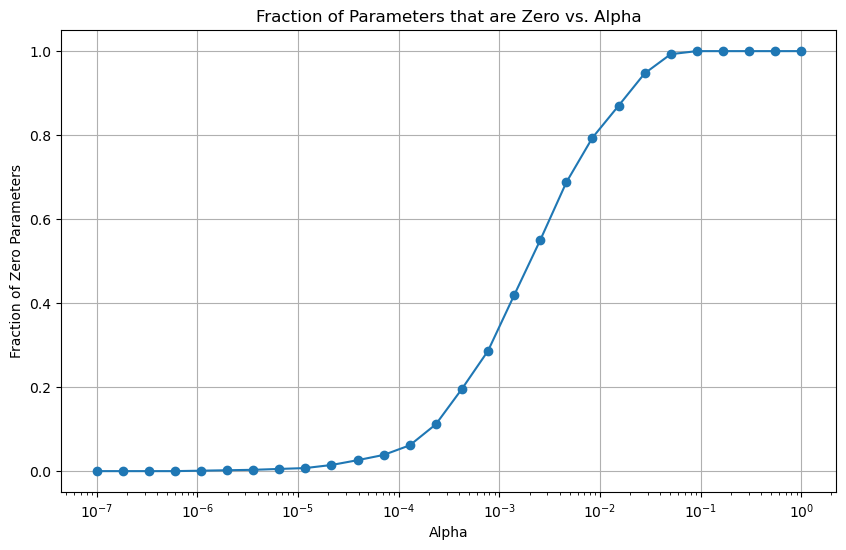

In [15]:
# TODO
# Plot the FRACTION of parameters that are exactly zero as a function of alpha
#  Set the xscale to 'log'

# Calculate the fraction of parameters that are zero for each alpha
fraction_zero = zero_count / Xtrain.shape[1]

# Plot the fraction of zero parameters vs. alpha
plt.figure(figsize=(10, 6))

# Plot the fraction of zero parameters
plt.plot(alphas, fraction_zero, marker='o', linestyle='-')
plt.xscale('log')

# Set labels, title, and grid
plt.xlabel('Alpha')
plt.ylabel('Fraction of Zero Parameters')
plt.title('Fraction of Parameters that are Zero vs. Alpha')
plt.grid(True)

# Show the plot
plt.show()


In [16]:
# TODO
# Identify and print the index in fvaf_valid that is best
idx_fvaf = np.argmax(fvaf_valid)
idx_fvaf

18

In [17]:
# TODO
# Show the alpha that corresponds to this best model
best_alpha = alphas[idx_fvaf]
best_alpha

0.004641588833612773

In [18]:
# TODO
# Identify and print the index in fvaf_rmse that is best
idx_rmse = np.argmin(rmse_valid)
idx_rmse

18

In [19]:
# TODO
# Show the alpha that corresponds to this best model
best_alpha = alphas[idx_rmse]
best_alpha


0.004641588833612773

In [20]:
# TODO
# Set the regularized model alpha to the best value with respect to FVAF
#  and fit the model to the training data

# Set the regularized model alpha to the best value
model_regularized.set_params(**{'lasso regression__alpha': best_alpha})

# Fit the model to the training data
model_regularized.fit(Xtrain, ytrain)


Pipeline(steps=[('scalar', StandardScaler()),
                ('lasso regression', Lasso(alpha=0.004641588833612773))])

In [21]:
# TODO
# Compute the predictions for the training data
predtrain = model_regularized.predict(Xtrain)
predtrain


array([1.78731619, 1.7356575 , 1.59293799, ..., 1.61634086, 1.52699118,
       1.43934527])

In [22]:
# TODO
# Compute the predictions for the test data
predtest = model_regularized.predict(Xtest)


# Report the fvaf and rmse for the test data
# TODO
_, rmse_deg, fvaf, _, _ = predict_score_eval(model_regularized, Xtest, ytest, convert_deg=True)
print(fvaf, rmse_deg)

0.45686500823191234 10.417040670640777


In [23]:
# TODO
# You have already fit the LinearRegression model to the training data
# (above).   Use it to predict arm movement for the test data
preds_lnr =  model_lnr.predict(Xtest)
preds_lnr

array([1.52820589, 1.44199878, 1.20780386, ..., 1.69936631, 1.4757866 ,
       1.40958614])

In [24]:
# Report the LinearRegression fvaf and rmse for the test data
# TODO
_, rmse_deg, fvaf, _, _ = predict_score_eval(model_lnr, Xtest, ytest, convert_deg=True)
print(fvaf, rmse_deg)

-0.4321978945720679 16.915778259137955


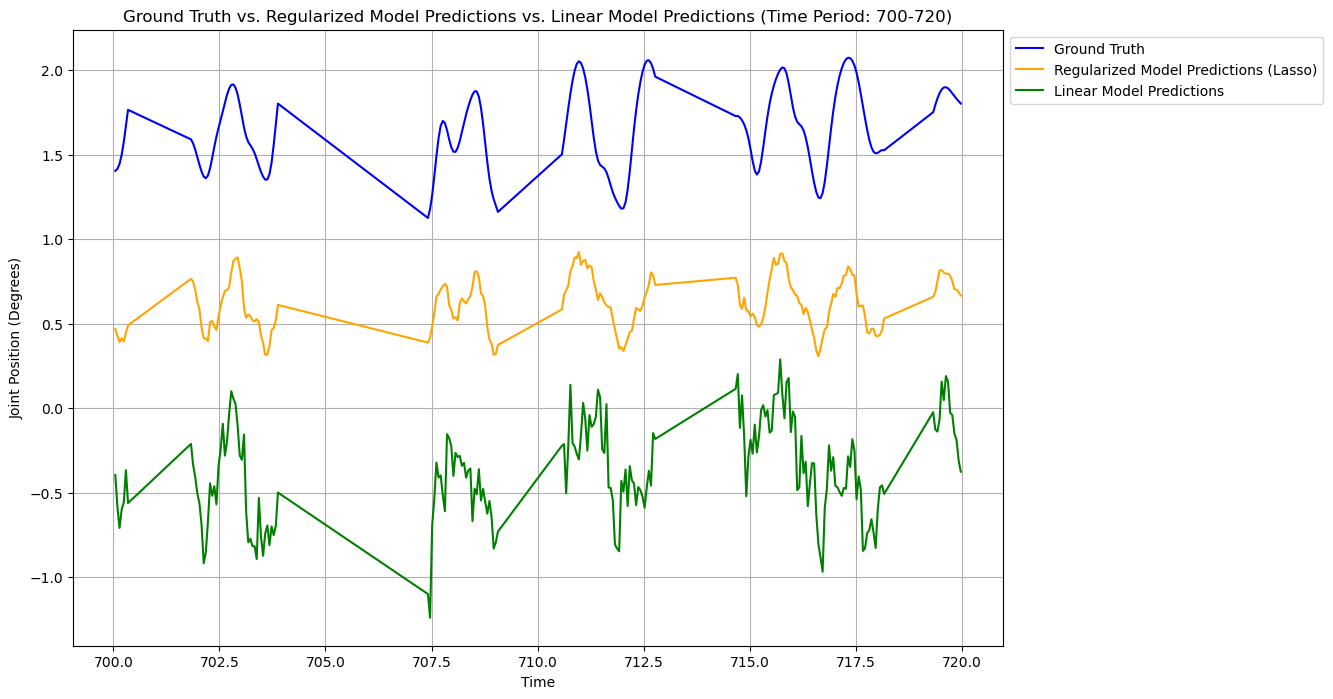

In [25]:
# TODO
# Plot: ground truth, regularized model predictions and the Linear model predictions for 
#  time period 700 to 720


# Define the time period to visualize
start_time = 700
end_time = 720
time_period = np.where((timetest >= start_time) & (timetest <= end_time))[0]

# Extract the ground truth, Lasso (regularized model) predictions, and Linear Regression predictions for the specified time period
y_true = ytest[time_period]
y_pred_reg = predtest[time_period]  # Predictions from the regularized model
y_pred_lnr = preds_lnr[time_period]  # Predictions from the Linear Regression model
time_segment = timetest[time_period]  # Corresponding time segment

# Plot the results
plt.figure(figsize=(12, 8))

plt.plot(time_segment, y_true, label='Ground Truth', linestyle='-', color='blue')
plt.plot(time_segment, y_pred_reg - 1, label='Regularized Model Predictions (Lasso)', linestyle='-', color='orange')
plt.plot(time_segment, y_pred_lnr - 2, label='Linear Model Predictions', linestyle='-', color='green')

# Add labels, title, and legend
plt.xlabel('Time')
plt.ylabel('Joint Position (Degrees)')
plt.title('Ground Truth vs. Regularized Model Predictions vs. Linear Model Predictions (Time Period: 700-720)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# Show the plot
plt.show()




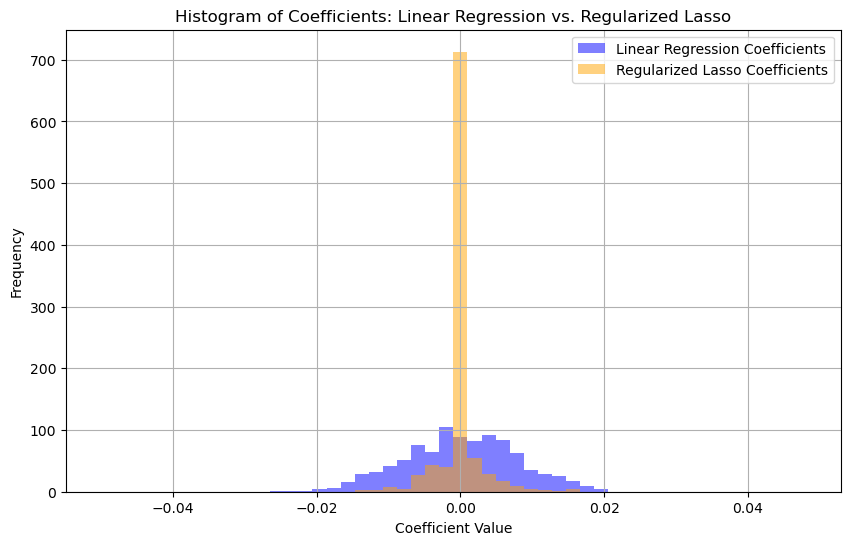

In [26]:
""" TODO: complete implementation
Generate a plot that contains two overlapping histograms:
- Coefficients discovered by LinearRegression
- Coefficients discovered by the best regularized model

"""
nbins = 51
start = -0.05
end = 0.05
incr = (end - start) / nbins
bins = np.arange(start, end, incr)

# When using plt.hist(), use bins=bins.  This will use the exact same bins for
#   both histograms
linear_coefficients = model_lnr.named_steps['linear regression'].coef_
lasso_coefficients = model_regularized.named_steps['lasso regression'].coef_

plt.figure(figsize=(10, 6))
# Plot overlapping histograms
plt.hist(linear_coefficients , bins=bins, alpha=0.5, label='Linear Regression Coefficients', color='blue')
plt.hist(lasso_coefficients, bins=bins, alpha=0.5, label='Regularized Lasso Coefficients', color='orange')

# Add labels and title
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.title('Histogram of Coefficients: Linear Regression vs. Regularized Lasso')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



In [27]:
# Number of non-zero coefficients in the best regularized model
non_zero_coefficients = np.sum(model_regularized.named_steps['lasso regression'].coef_ != 0)

print(f"Number of non-zero coefficients in the best regularized model: {non_zero_coefficients}")


Number of non-zero coefficients in the best regularized model: 300


## Reflection
Respond to each of the following questions with short answers.

_Q1. For the simple LinearRegression model, what is the difference in performance between the training and test sets?  Explain this difference_

Linear Regression model had high fvaf and low rmse in training But in test set it was opposite ie high rmse and low fvaf. Meaning the model was overfitting and not regularizing properly.


_Q2. For the FVAF vs alpha curves, describe the difference between the training and validation data sets.  Explain this difference._

Training FVAF starts high and it goes down and stabilizes But Test FVAF starts low then goes high at alpha value 0.004641588833612773 then it reduces.

_Q3.  Referring to the figure showing the Zero Coefficient Count as a function of alpha, describe and then explain the shape of the curve._

The shape is a sigmoid or S shape. As alpha increases, the model complexity decreases because many coefficients are set to zero.

_Q4. How does the performance of the best Regularized Model compare to that of the LinearRegression model with respect to the test data set?_

FVAF and RMSE of linear model for test data is  : -0.4321978945720706 , 16.915778259137973
FVAF and RMSE of Regularized model for test data is : 0.45686500823191234 0.18181165801683977
The performence of regularized model is better.


_Q5. How many non-zero coefficients are there for the best regularized model?_

Number of non-zero coefficients in the best regularized model: 300


_Q6. Why are the model coefficient distributions different for the LinearRegression and the Lasso models?_

Its Because LASSO has a new penalty term in its cost function which introduces regularization.

_Q7. True or False? The best choice of alpha is the same whether we are optimizing for FVAF or RMSE._

TRUE, The best choice of alpha is the same whether we are optimizing for FVAF or RMSE.

_Q8. Compare and contrast the three joint position curves in the above figure._

The linear model has high variance compared to regularized model. The Regualarized model feels like its too much regularized.

